In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import Dense, Input, Dropout
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
def generator():
    gen = Sequential()
    gen.add(Dense(units = 128, input_dim=100))
    gen.add(LeakyReLU(0.2))
    
    gen.add(Dense(units = 256))
    gen.add(LeakyReLU(0.2))
    
    gen.add(Dense(units = 512))
    gen.add(LeakyReLU(0.2))
    
    gen.add(Dense(units = 784, activation = 'tanh'))
    gen.compile(loss='binary_crossentropy',optimizer=Adam())
    
    return gen

In [4]:
g = generator()

In [5]:
g.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)              

In [9]:
def discriminator():
    dis = Sequential()
    dis.add(Dense(units = 512, input_dim=784))
    dis.add(LeakyReLU(0.2))
    dis.add(Dropout(0.4))
    
    dis.add(Dense(units = 256))
    dis.add(LeakyReLU(0.2))
    dis.add(Dropout(0.4))
    
    dis.add(Dense(units = 128))
    dis.add(LeakyReLU(0.2))
    
    dis.add(Dense(units = 1, activation = 'sigmoid'))
    dis.compile(loss='binary_crossentropy',optimizer=Adam())
    
    return dis

In [10]:
d = discriminator()

In [11]:
d.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [12]:
def gan(dis, gen):
    gan_input = Input(shape=(100,))
    x = gen(gan_input)
    gan_output = dis(x)
    gan_model = Model(inputs = gan_input, outputs = gan_output)
    gan_model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
    
    return gan_model

In [13]:
gan_obj = gan(d,g)

In [14]:
gan_obj.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               579728    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 566273    
Total params: 1,146,001
Trainable params: 1,146,001
Non-trainable params: 0
_________________________________________________________________


In [33]:
def plot_images(epoch, gen, examples = 100, dim = (10,10)):
    noise = np.random.normal(0,1,[examples,100])
    gen_images = gen.predict(noise)
    gen_images = gen_images.reshape(100,28,28)
    plt.figure(figsize=(10,10))
    for i in range(gen_images.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(gen_images[i])
        plt.axis('off')
    plt.tight_layout()

In [34]:
noise = np.random.normal(0,1,[128,100])
gen_images = generator().predict(noise)

In [35]:
gen_images.shape

(128, 784)

In [36]:
img_batch = x_train[np.random.randint(0,x_train.shape[0],size=128)]

In [37]:
img_batch.shape

(128, 28, 28)

In [38]:
def training(epochs, batch_size=128):
    n = x_train.shape[0]
    batch_count = n / batch_size
    
    gen = generator()
    dis = discriminator()
    gan_obj = gan(dis, gen)
    for i in range(epochs):
        for j in range(batch_size):
            noise = np.random.normal(0,1,[batch_size,100])
            gen_images = gen.predict(noise)
            img_batch = x_train[np.random.randint(0,n,size=batch_size)]
            img_batch = img_batch.reshape(batch_size, -1)
            
            X = np.concatenate([img_batch, gen_images])
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 0.9
            
            dis.trainable = True
            dis.train_on_batch(X, y_dis)
            
            noise = np.random.normal(0,1,[batch_size, 100])
            y_gen = np.ones(batch_size)
            
            dis.trainable = False
            
            gan_obj.train_on_batch(noise, y_gen)
            
        if i % 20 == 0:
            plot_images(i, gen)

C:\Users\asus\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


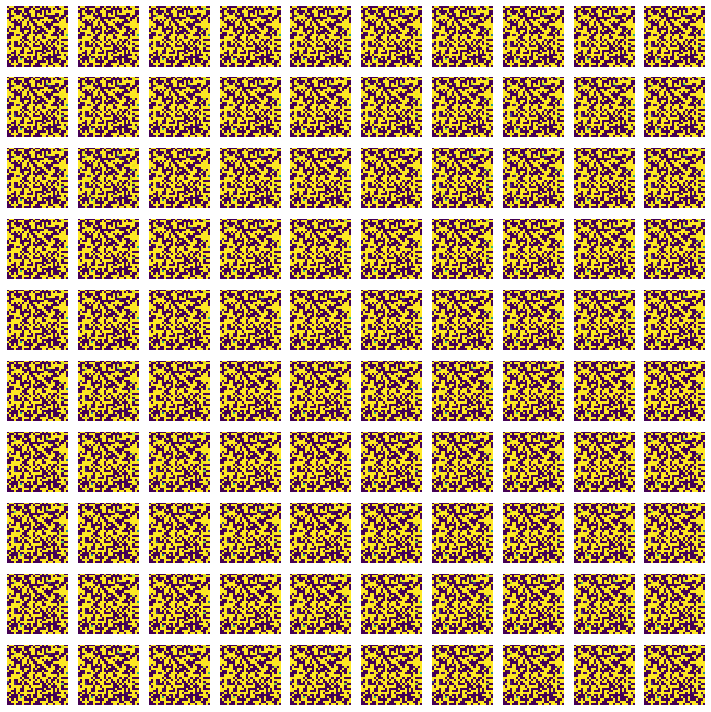

In [39]:
training(2)